In [1]:
import igraph as ig
import numpy as np
from numpy.linalg import norm
import random
import pandas as pd
import scipy.io
import time
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from IPython.display import display, clear_output
from operator import itemgetter
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from SOINN import SF_SOINN


See for reference: https://www.kaggle.com/kooaslansefat/cicids2017-safeml

## Auxiliary functions

In [2]:
def train_phase(model, data, labels):
    """
    Training phase where data is fitted into the model.

    Parameters
    ----------
    model : SF_SOINN network
        The network to train.
    data : dataframe
        Input dataset with normalized features.
    labels : array, shape=[n_examples]
        Labels associated to the examples in the input dataset.

    Returns
    -------
    xs : list
        List of x values (for plotting).
    n_nodes : list
        List that containes the number of nodes for each xs (for plotting).
    n_edges : list
        List that containes the number of edges for each xs (for plotting).
    n_del_nodes : list
        List that containes the number of deleted nodes for each xs (for plotting).
    n_del_edges : list
        List that containes the number of deleted edges for each xs (for plotting).
    """
    # for plotting
    xs = []
    n_nodes = []
    n_edges = []
    n_del_nodes = []
    n_del_edges = []

    start_time = time.time()

    for index, row in data.iterrows():
        model.input_signal(x=row.values, y=labels[index], learning=True)

        # print completed percentage
        percent_completed = round((index / len(data))*100, 2)
        if index % 100 == 0 or index == len(data):
            clear_output(wait=True)
            print(f'Processing input {index}: {percent_completed}% completed')
            # for plotting
            n_nodes.append(model.network.vcount())
            n_edges.append(model.network.ecount())
            n_del_nodes.append(model.n_del_nodes)
            n_del_edges.append(model.n_del_edges)
            xs.append(index)

    finish_time = round(time.time() - start_time)
    mins = round(finish_time / 60)
    secs = finish_time % 60
    clear_output(wait=True)
    print(f'Training time: {mins} min {secs} sec')
    print(f'Inputs processed: {index}')

    print(f'Number of nodes: {model.network.vcount()}')
    print(f'Number of edges: {model.network.ecount()}')

    return xs, n_nodes, n_edges, n_del_nodes, n_del_edges

In [3]:
def update_phase(model, data, labels, show_stats=True):
    """
    Update phase where predictions are made, and the wrong ones get fed back. Outputs the performance metrics.

    Parameters
    ----------
    model : SF_SOINN network
        The network to train.
    data : dataframe
        Input dataset with normalized features.
    labels : array, shape=[n_examples]
        Labels associated to the examples in the input dataset.
    show_stats : boolean (default: True)
        If True, show statistics and performance metrics.
    """
    predicted = []
    # Positive = is an attack
    # Negative = normal connection

    # True Positives (TP): number of correctly predicted attacks
    tp = 0
    # False Negatives (FN): anomalies classified as normal
    fn = 0
    # False Positives (FP): normal connections classified as anomalies
    fp = 0
    # True Negatives (TN): number of correctly predicted normal connections
    tn = 0

    # evaluation metrics

    # True Positive Rate (TPR) or Detection Rate (DR): ratio between the number of correctly predicted attacks and the total number of attacks, also called Detection Rate (DR)
    # TPR = TP / (TP + FN)
    tpr = 1
    # False Positive Rate (FPR): ratio between the number of normal instances incorrectly classified as attacks and the total number of normal instances
    # FPR = FP / (FP + TN)
    fpr = 1
    # False Negative Rate (FNR): failed to identify an anomaly and classified as normal
    # FNR = FN / (FN + TP)
    fnr = 1
    # Positive Predictive Value (PPV): chance of intrusion detected if an alarm is issued by the IDS
    # PPV = TP / (TP + FP)
    ppv = 1
    # Negative Predictive Value (NPV): chance that there is no intrusion when IDS does not output an alarm
    # NPV = TN / (TN + FN)
    npv = 1
    # Classification Rate (CR) or Accuracy: percentage of all those correctly predicted instances to all instances, also known as Accuracy
    # CR = (TP + TN) / (TP + TN + FP + FN)
    accuracy = 1
    # Base Rate (B): probability of input being an attack
    # B = (TP + FN) / (TP + TN + FP + FN)
    b = 1
    # Intrusion Detection Capability (CID): ratio of the mutual information between input and output and the entropy of the input
    # CID = (H(X) - H(X | Y)) / H(X)
    cid = 1

    start_time = time.time()

    for index, row in data.iterrows():
        x = row.values
        y = labels[index]
        # predicted label
        yp, _ = model.input_signal(x=x, learning=False)
        predicted.append(yp)

        # feedback loop
        if y != yp:
            model.input_signal(x=x, y=y, learning=True)

        # true positive count
        if yp != 'normal' and y != 'normal':
            tp += 1
        # false positive count
        if yp != 'normal' and y == 'normal':
            fp += 1
        # true negatives count
        if yp == 'normal' and y == 'normal':
            tn += 1
        # false negative count
        if yp == 'normal' and y != 'normal':
            fn += 1

        # print completed percentage
        percent_completed = round((index / len(data))*100, 2)
        if index % 100 == 0 or index == len(data):
            clear_output(wait=True)
            print(f'Predictions completed: {percent_completed}%')
            
    clear_output(wait=True)
    if show_stats:
        finish_time = round(time.time() - start_time)
        mins = round(finish_time / 60)
        secs = finish_time % 60

        # metrics computation
        if (tp + fn) > 0:
            tpr = tp / (tp + fn)
        if (fp + tn) > 0:
            fpr = fp / (fp + tn)
        if (fn + tp) > 0:
            fnr = fn / (fn + tp)
        if (tp + fp) > 0:
            ppv = tp / (tp + fp)
        if (tn + fn) > 0:
            npv = tn / (tn + fn)
        if (tp + tn + fp + fn) > 0:
            accuracy = (tp + tn) / (tp + tn + fp + fn)
            b = (tp + fn) / (tp + tn + fp + fn)
        # entropy H(X)
        if b > 0 and (1-b) > 0:
            h_x = -b * math.log(b) - (1-b) * math.log(1-b)
        else:
            h_x = 0
        # entropy H(X | Y)
        # formula is a bit complicated, reference thesis for it
        # two equal versions for entropy
        # this version uses ppv and npv values
        #h_x_y = -b * (1-fnr) * math.log(ppv) - b * fnr * math.log(1 - npv) - (1-b) * (1-fpr) * math.log(npv) - (1-b) * fpr * math.log(1-ppv)
        # this version does not use ppv and npv
        if (b * (1 - fnr) + (1 - b) * fpr) != 0 and (b * (1 - fnr) / (b * (1 - fnr) + (1 - b) * fpr)):
            h_x_y = -b * (1 - fnr) * math.log(b * (1 - fnr) / (b * (1 - fnr) + (1 - b) * fpr))
        else:
            h_x_y = 0
        if (b * fnr + (1 - b) * (1-fpr)) != 0 and (b * fnr / (b * fnr + (1 - b) * (1-fpr))) > 0:
            h_x_y -= b * fnr * math.log( b * fnr / (b * fnr + (1 - b) * (1-fpr)) )
        else:
            h_x_y -= 0
        if ((1 - b) * (1 - fpr) + b * fnr) != 0 and ((1 - b) * (1 - fpr) / ((1 - b) * (1 - fpr) + b * fnr)) > 0:
            h_x_y -= (1 - b) * (1 - fpr) * math.log( (1 - b) * (1 - fpr) / ((1 - b) * (1 - fpr) + b * fnr) )
        else:
            h_x_y -= 0
        if ((1 - b) * fpr + b * (1 - fnr)) != 0 and ((1 - b) * fpr / ((1 - b) * fpr + b * (1 - fnr))) > 0:
            h_x_y -= (1 - b) * fpr * math.log( (1 - b) * fpr / ((1 - b) * fpr + b * (1 - fnr)) )
        else:
            h_x_y -= 0

        if h_x == 0 or h_x == 1:
            cid = 1
        else:
            cid = (h_x - h_x_y) / h_x

        clear_output(wait=True)
        print(f'Update phase time: {mins} min {secs} sec')
        print(f'Inputs processed: {index}')

        print(f'Accuracy (percentage of correctly predicted instances): {round(accuracy * 100, 2)}%')
        print(f'Detection Rate (TPR): {round(tpr * 100, 2)}%')
        print(f'False Positive Rate (FPR - normal classified as attacks): {round(fpr * 100, 2)}%')
        print(f'False Negatives Rate (FNR - attacks classified as normal): {round(fnr * 100, 2)}%')
        print(f'Intrusion Detection Capability (CID): {round(cid * 100, 2)}%')

        # creating a frequency dict for visualizing the attacks with the most mistakes
        errors_freq = dict()
        for i in range(len(labels)):
            if labels[i] != predicted[i]:
                errors_freq[f'{labels[i]}-{predicted[i]}'] = 0
        for i in range(len(labels)):
            if labels[i] != predicted[i]:
                errors_freq[f'{labels[i]}-{predicted[i]}'] += 1
        # sort frequency dictionary
        errors_freq = dict(sorted(errors_freq.items(), key=itemgetter(1), reverse=True))
        print('\n\n')
        print(errors_freq)

        return round(accuracy * 100, 2), round(tpr * 100, 2), round(fpr * 100, 2), round(fnr * 100, 2), round(cid * 100, 2)


# Import and prepare data

In [4]:
# read datasets and shuffle them
ddos = pd.read_csv('./CIC-IDS-2017/ddos.csv').sample(frac=1).reset_index(drop=True)
infilteration = pd.read_csv('./CIC-IDS-2017/infilteration.csv').sample(frac=1).reset_index(drop=True)
#normal1 = pd.read_csv('./CIC-IDS-2017/normal1.csv').sample(frac=1).reset_index(drop=True)
#normal2 = pd.read_csv('./CIC-IDS-2017/normal2.csv').sample(frac=1).reset_index(drop=True)
#normal3 = pd.read_csv('./CIC-IDS-2017/normal3.csv').sample(frac=1).reset_index(drop=True)
#normal4 = pd.read_csv('./CIC-IDS-2017/normal4.csv').sample(frac=1).reset_index(drop=True)
portscan = pd.read_csv('./CIC-IDS-2017/portscan.csv').sample(frac=1).reset_index(drop=True)
webattacks = pd.read_csv('./CIC-IDS-2017/webattacks.csv').sample(frac=1).reset_index(drop=True)


In [5]:
# concatenating all datasets into one, shuffling, and resetting index
df = pd.concat([ddos, infilteration, portscan, webattacks]).sample(frac=1).reset_index(drop=True)
#df = pd.concat([ddos, infilteration, normal1, normal2, normal3, normal4, portscan, webattacks]).sample(frac=1).reset_index(drop=True)


In [6]:
# removing unnecessary column
df.drop([' Destination Port'], axis=1, inplace=True)
#df.drop([' Destination Port', ' Bwd Packet Length Mean', ' Avg Bwd Segment Size',
#         'Bwd Packet Length Max', ' Packet Length Std', ' Average Packet Size', ' Packet Length Mean', ' Max Packet Length', ' Packet Length Variance', ' Idle Max', ' Fwd IAT Max', ' Flow IAT #Std', ' Idle Std', 'Idle Mean'], axis=1, inplace=True)


In [7]:
# cleaning dataframe from strange values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()
df = df.reset_index(drop=True)

In [8]:
# extracting labels and removing them from df
labels = df[' Label'].replace('BENIGN', 'normal')
df.drop([' Label'], axis=1, inplace=True)
df = df.reset_index(drop=True)

## Feature scaling

In [9]:
# scaler
df_features = df.columns.tolist()
df_scaled = StandardScaler().fit_transform(df)
# converting back to dataframe
df = pd.DataFrame(data=df_scaled, columns=df_features)

In [10]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,-0.173017,-0.007759,-0.009718,-0.037681,-0.006606,-0.224440,-0.222977,-0.250830,-0.190071,-0.397968,...,-0.009713,0.912875,-0.140055,-0.097374,-0.158242,-0.121403,-0.297742,-0.141846,-0.296748,-0.269249
1,-0.362739,-0.009875,-0.008129,-0.032644,-0.006445,-0.186785,0.219907,-0.110903,-0.190071,-0.343740,...,-0.007503,0.912875,-0.140055,-0.097374,-0.158242,-0.121403,-0.297742,-0.141846,-0.296748,-0.269249
2,-0.362740,-0.009875,-0.008129,-0.032100,-0.006528,-0.182714,0.267787,-0.095776,-0.190071,-0.371549,...,-0.007503,0.912875,-0.140055,-0.097374,-0.158242,-0.121403,-0.297742,-0.141846,-0.296748,-0.269249
3,-0.361060,-0.009875,-0.008129,-0.032508,-0.006482,-0.185767,0.231877,-0.107121,-0.190071,-0.356254,...,-0.007503,0.912875,-0.140055,-0.097374,-0.158242,-0.121403,-0.297742,-0.141846,-0.296748,-0.269249
4,-0.362744,-0.011991,-0.009718,-0.037681,-0.006602,-0.224440,-0.222977,-0.250830,-0.190071,-0.395187,...,-0.009713,2.070640,-0.140055,-0.097374,-0.158242,-0.121403,-0.297742,-0.141846,-0.296748,-0.269249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970428,-0.361658,-0.009875,-0.008129,-0.032236,-0.006467,-0.183732,0.255817,-0.099558,-0.190071,-0.351156,...,-0.007503,-0.823772,-0.140055,-0.097374,-0.158242,-0.121403,-0.297742,-0.141846,-0.296748,-0.269249
970429,-0.359447,-0.007759,-0.004952,-0.035912,0.001376,-0.204086,-0.222977,-0.218054,-0.164951,4.976096,...,-0.005293,-0.823772,-0.140055,-0.097374,-0.158242,-0.121403,-0.297742,-0.141846,-0.296748,-0.269249
970430,-0.362745,-0.009875,-0.008129,-0.037409,-0.006598,-0.222405,-0.199037,-0.243266,-0.190071,-0.395187,...,-0.007503,-0.244890,-0.140055,-0.097374,-0.158242,-0.121403,-0.297742,-0.141846,-0.296748,-0.269249
970431,-0.347811,-0.007759,-0.004952,0.002205,-0.006128,0.371939,-0.222977,0.487881,0.638015,-0.075385,...,-0.007503,0.912875,-0.140055,-0.097374,-0.158242,-0.121403,-0.297742,-0.141846,-0.296748,-0.269249


## PCA

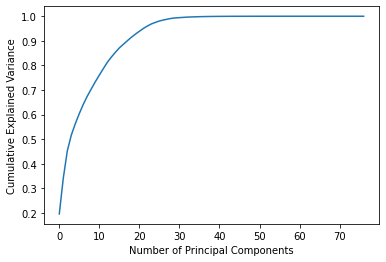

In [11]:
pca_test = PCA().fit(df)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


30 features are enough to explain most of the variance

In [12]:
pca = PCA(n_components=30)
principal_components = pca.fit(df).transform(df)
principal_components


array([[-0.95252112,  0.002948  ,  0.59574658, ...,  0.24261242,
         0.00924548,  0.42850741],
       [-1.71064059,  0.03845255,  0.53881616, ..., -0.17013363,
         0.18068892, -0.01953522],
       [-1.73332845,  0.03780916,  0.61281564, ..., -0.09114523,
        -0.50602767, -0.01898144],
       ...,
       [-1.63558072,  0.04491761,  0.24765793, ...,  0.12709152,
         0.08764886, -0.04843492],
       [-0.80678735,  0.0488307 , -0.5078988 , ...,  0.09109186,
        -0.04450721,  0.03040919],
       [-1.58582268,  0.03111522,  0.45566929, ...,  0.23778152,
        -0.01107026, -0.04203922]])

In [13]:
# transforming back into dataframe
df = pd.DataFrame(data=principal_components, columns=[i for i in range(30)])
df


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.952521,0.002948,0.595747,-0.311348,1.334000,0.999705,-1.769970,-0.652984,-0.365901,0.020796,...,-0.036604,-0.506429,0.495896,-0.293186,-0.055505,-0.233122,-0.061209,0.242612,0.009245,0.428507
1,-1.710641,0.038453,0.538816,-0.232919,-0.724304,0.632729,1.333427,0.201022,-0.112607,-0.045175,...,-0.448184,0.199853,0.104221,0.045638,-0.391023,-0.169003,0.086699,-0.170134,0.180689,-0.019535
2,-1.733328,0.037809,0.612816,-0.147435,-0.569853,0.535116,1.066337,0.119073,-0.087699,-0.036847,...,-0.231316,0.074774,-0.010679,0.017505,-0.442265,-0.415149,0.509284,-0.091145,-0.506028,-0.018981
3,-1.704547,0.037559,0.563942,-0.205142,-0.659514,0.659418,1.268467,0.137114,-0.173170,-0.036402,...,-0.364678,0.014781,0.116480,0.044417,-0.437483,-0.269449,0.268879,-0.135244,-0.106063,-0.020121
4,-1.721889,0.050128,0.274553,-0.180950,0.991670,1.166629,-1.609488,-0.185008,-0.419240,-0.070655,...,-0.212266,-0.160149,0.138945,-0.099071,-0.093588,-0.031687,0.070132,0.105788,0.099415,0.009970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970428,-1.585901,0.031802,0.463402,-0.191854,-0.853466,0.457808,1.595063,0.154533,-0.000906,-0.010954,...,0.230236,0.023730,0.096478,-0.019559,0.357755,0.350359,0.063667,0.229977,-0.116557,-0.065282
970429,5.483073,0.032583,-12.379819,-2.571408,-2.374168,-0.310602,-0.818155,1.336869,0.175534,-0.047337,...,-1.406060,0.377197,0.153376,-0.186670,-0.149418,-1.691646,0.554564,2.383026,0.609973,-0.436020
970430,-1.635581,0.044918,0.247658,-0.123467,0.490736,0.287027,-0.810267,-0.142048,0.263230,-0.019195,...,1.138396,0.460604,0.283813,0.047468,-0.255869,-0.042975,-0.107699,0.127092,0.087649,-0.048435
970431,-0.806787,0.048831,-0.507899,0.769236,0.296086,1.407076,-1.621366,0.000324,-0.259783,-0.049151,...,0.079354,-0.366498,0.148640,-0.151813,0.166783,0.484432,0.081272,0.091092,-0.044507,0.030409


## Balanced train and test split

Using stratified K-fold split, the test & train splits must have the the same proportions of the target classes. Otherwise, the problem with splitting the data randomly can cause a class misrepresentation - i.e., one or more of the target classes are represented more in test/train split than the others. It could lead to bias in the training of the model.

In [14]:
# use this when working only with a part of the dataset (like 300000 rows)
#df = df[:300000]
#labels = labels[:300000]

In [15]:
labels.unique()

array(['normal', 'PortScan', 'DDoS', 'Web Attack � Brute Force',
       'Web Attack � XSS', 'Infiltration', 'Web Attack � Sql Injection'],
      dtype=object)

10 folds is usually the heuristic to follow for larger datasets of around this size (n_splits=10)

In [16]:
X = df
y = labels

skf = StratifiedKFold(n_splits=10, shuffle=False)
skf

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [17]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    reshaped_y_train = np.asarray(y_train).reshape(-1, 1)
    reshaped_y_test = np.asarray(y_test).reshape(-1, 1)

print('X_train length: ', len(X_train))
print('y_train length: ', len(y_train))
print('X_test length: ', len(X_test))
print('y_test length: ', len(y_test))

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


X_train length:  873390
y_train length:  873390
X_test length:  97043
y_test length:  97043


# SF-SOINN classification

In [ ]:
rand_int = random.randint(1, len(X_train) - 1)
x1 = X_train.iloc[rand_int].values
rand_int = random.randint(1, len(X_train) - 1)
x2 = X_train.iloc[rand_int].values
rand_int = random.randint(1, len(X_train) - 1)
x3 = X_train.iloc[rand_int].values

s = SF_SOINN.SF_SOINN(x1, x2, x3, max_edge_age=100, iter_lambda=1000)

_, _, _, _, _ = train_phase(model=s, data=X_train, labels=y_train)


In [ ]:
i = 0
color_dict = dict()
classes = np.unique(np.append(y_train, y_test))
palette = ig.ClusterColoringPalette(len(classes))
for c in classes:
    if c == 'normal':
        color_dict[c] = 'blue'
    else:
        color_dict[c] = 'red'
    i += 1

# for saving as PNG
#ig.plot(s.network, 'network.png', vertex_size=5, vertex_color=[color_dict[c] for c in s.network.vs['c']])
ig.plot(s.network, vertex_size=5, vertex_color=[color_dict[c] for c in s.network.vs['c']])

In [ ]:
_, _, _, _, _ = update_phase(model=s, data=X_test, labels=y_test)


# Attack-based training

Initial training on DoS and Normal, incremental training on the rest.

In [19]:
# auxiliary function
def make_test(model, data, labels, title):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    tpr = 0
    fnr = 0
    accuracy = 0

    for index, row in data.iterrows():
        x = row.values
        y = labels[index]
        yp, _ = model.input_signal(x=x, learning=False)
        # feedback loop
        #if y != yp:
        #    model.input_signal(x=x, y=y, learning=True)

        # for metrics computation
        if yp != 'normal' and y != 'normal':
            tp += 1
        if yp != 'normal' and y == 'normal':
            fp += 1
        if yp == 'normal' and y == 'normal':
            tn += 1
        if yp == 'normal' and y != 'normal':
            fn += 1

    # metrics computation
    if (tp + fn) > 0:
        tpr = tp / (tp + fn)
    if (fn + tp) > 0:
        fnr = fn / (fn + tp)
    if (tp + tn + fp + fn) > 0:
        accuracy = (tp + tn) / (tp + tn + fp + fn)

    print(title)
    print(
        f'Accuracy (percentage of correctly predicted instances): {round(accuracy * 100, 2)}%')
    print(f'Detection Rate (TPR): {round(tpr * 100, 2)}%')
    print(
        f'False Negatives Rate (FNR - attacks classified as normal): {round(fnr * 100, 2)}%')


In [18]:
indexes_normal = [i for i, n in enumerate(y_train) if n == 'normal']
indexes_ddos = [i for i, n in enumerate(y_train) if n == 'DDoS']
indexes_portscan = [i for i, n in enumerate(y_train) if n == 'PortScan']
indexes_crosssite = [i for i, n in enumerate(y_train) if n == 'Web Attack � XSS']
indexes_bruteforce = [i for i, n in enumerate(y_train) if n == 'Web Attack � Brute Force']
indexes_infiltration = [i for i, n in enumerate(y_train) if n == 'Infiltration']
indexes_sqlinjection = [i for i, n in enumerate(y_train) if n == 'Web Attack � Sql Injection']

indexes_normal_test = [i for i, n in enumerate(y_test) if n == 'normal']
indexes_ddos_test = [i for i, n in enumerate(y_test) if n == 'DDoS']
indexes_portscan_test = [i for i, n in enumerate(y_test) if n == 'PortScan']
indexes_crosssite_test = [i for i, n in enumerate(y_test) if n == 'Web Attack � XSS']
indexes_bruteforce_test = [i for i, n in enumerate(y_test) if n == 'Web Attack � Brute Force']
indexes_infiltration_test = [i for i, n in enumerate(y_test) if n == 'Infiltration']
indexes_sqlinjection_test = [i for i, n in enumerate(y_test) if n == 'Web Attack � Sql Injection']

### Creation of the incremental datasets

In [20]:
X_normal_train = X_train.filter(items=indexes_normal, axis=0)
y_normal_train = y_train.filter(items=indexes_normal, axis=0)
X_normal_test = X_test.filter(items=indexes_normal_test, axis=0)
y_normal_test = y_test.filter(items=indexes_normal_test, axis=0)

X_ddos_train = X_train.filter(items=indexes_ddos, axis=0)
y_ddos_train = y_train.filter(items=indexes_ddos, axis=0)
X_ddos_test = X_test.filter(items=indexes_ddos_test, axis=0)
y_ddos_test = y_test.filter(items=indexes_ddos_test, axis=0)

X_portscan_train = X_train.filter(items=indexes_portscan, axis=0)
y_portscan_train = y_train.filter(items=indexes_portscan, axis=0)
X_portscan_test = X_test.filter(items=indexes_portscan_test, axis=0)
y_portscan_test = y_test.filter(items=indexes_portscan_test, axis=0)

X_crosssite_train = X_train.filter(items=indexes_crosssite, axis=0)
y_crosssite_train = y_train.filter(items=indexes_crosssite, axis=0)
X_crosssite_test = X_test.filter(items=indexes_crosssite_test, axis=0)
y_crosssite_test = y_test.filter(items=indexes_crosssite_test, axis=0)

X_bruteforce_train = X_train.filter(items=indexes_bruteforce, axis=0)
y_bruteforce_train = y_train.filter(items=indexes_bruteforce, axis=0)
X_bruteforce_test = X_test.filter(items=indexes_bruteforce_test, axis=0)
y_bruteforce_test = y_test.filter(items=indexes_bruteforce_test, axis=0)

X_infiltration_train = X_train.filter(items=indexes_infiltration, axis=0)
y_infiltration_train = y_train.filter(items=indexes_infiltration, axis=0)
X_infiltration_test = X_test.filter(items=indexes_infiltration_test, axis=0)
y_infiltration_test = y_test.filter(items=indexes_infiltration_test, axis=0)

X_sqlinjection_train = X_train.filter(items=indexes_sqlinjection, axis=0)
y_sqlinjection_train = y_train.filter(items=indexes_sqlinjection, axis=0)
X_sqlinjection_test = X_test.filter(items=indexes_sqlinjection_test, axis=0)
y_sqlinjection_test = y_test.filter(items=indexes_sqlinjection_test, axis=0)


### Incremental training and testing

In [21]:
# initial train on normal and DDoS
rand_int = random.randint(1, len(X_normal_train) - 1)
x1 = X_normal_train.iloc[rand_int].values
rand_int = random.randint(1, len(X_normal_train) - 1)
x2 = X_normal_train.iloc[rand_int].values
rand_int = random.randint(1, len(X_normal_train) - 1)
x3 = X_normal_train.iloc[rand_int].values

s = SF_SOINN.SF_SOINN(x1, x2, x3, max_edge_age=100, iter_lambda=1000)

_, _, _, _, _ = train_phase(model=s, data=X_normal_train, labels=y_normal_train)
_, _, _, _, _ = train_phase(model=s, data=X_ddos_train, labels=y_ddos_train)

make_test(model=s, data=X_normal_test,
          labels=y_normal_test, title="----- Normal -----")
make_test(model=s, data=X_ddos_test,
          labels=y_ddos_test, title="----- DDoS -----")
make_test(model=s, data=X_portscan_test,
          labels=y_portscan_test, title="----- Portscan -----")
make_test(model=s, data=X_crosssite_test, labels=y_crosssite_test,
          title="----- Cross-Site Scripting -----")
make_test(model=s, data=X_bruteforce_test,
          labels=y_bruteforce_test, title="----- Bruteforce -----")
make_test(model=s, data=X_infiltration_test,
          labels=y_infiltration_test, title="----- Infiltration -----")
make_test(model=s, data=X_sqlinjection_test,
          labels=y_sqlinjection_test, title="----- SQL Injection -----")


Processing input 763200: 124.45% completed


In [ ]:
# Portscan
_, _, _, _, _ = train_phase(
    model=s, data=X_portscan_train, labels=y_portscan_train)
make_test(model=s, data=X_normal_test,
          labels=y_normal_test, title="----- Normal -----")
make_test(model=s, data=X_ddos_test,
          labels=y_ddos_test, title="----- DDoS -----")
make_test(model=s, data=X_portscan_test,
          labels=y_portscan_test, title="----- Portscan -----")
make_test(model=s, data=X_crosssite_test, labels=y_crosssite_test,
          title="----- Cross-Site Scripting -----")
make_test(model=s, data=X_bruteforce_test,
          labels=y_bruteforce_test, title="----- Bruteforce -----")
make_test(model=s, data=X_infiltration_test,
          labels=y_infiltration_test, title="----- Infiltration -----")
make_test(model=s, data=X_sqlinjection_test,
          labels=y_sqlinjection_test, title="----- SQL Injection -----")


In [ ]:
# Crossite
_, _, _, _, _ = train_phase(
    model=s, data=X_crosssite_train, labels=y_crosssite_train)
make_test(model=s, data=X_normal_test,
          labels=y_normal_test, title="----- Normal -----")
make_test(model=s, data=X_ddos_test,
          labels=y_ddos_test, title="----- DDoS -----")
make_test(model=s, data=X_portscan_test,
          labels=y_portscan_test, title="----- Portscan -----")
make_test(model=s, data=X_crosssite_test, labels=y_crosssite_test,
          title="----- Cross-Site Scripting -----")
make_test(model=s, data=X_bruteforce_test,
          labels=y_bruteforce_test, title="----- Bruteforce -----")
make_test(model=s, data=X_infiltration_test,
          labels=y_infiltration_test, title="----- Infiltration -----")
make_test(model=s, data=X_sqlinjection_test,
          labels=y_sqlinjection_test, title="----- SQL Injection -----")


Training time: 0 min 8 sec
Inputs processed: 863521
Number of nodes: 2323
Number of edges: 4760
----- Normal -----
Accuracy (percentage of correctly predicted instances): 94.6%
Detection Rate (TPR): 0%
False Negatives Rate (FNR - attacks classified as normal): 0%
----- DDoS -----
Accuracy (percentage of correctly predicted instances): 99.88%
Detection Rate (TPR): 99.88%
False Negatives Rate (FNR - attacks classified as normal): 0.12%
----- Portscan -----
Accuracy (percentage of correctly predicted instances): 0.32%
Detection Rate (TPR): 0.32%
False Negatives Rate (FNR - attacks classified as normal): 99.68%
----- Cross-Site Scripting -----
Accuracy (percentage of correctly predicted instances): 98.46%
Detection Rate (TPR): 98.46%
False Negatives Rate (FNR - attacks classified as normal): 1.54%
----- Bruteforce -----
Accuracy (percentage of correctly predicted instances): 80.79%
Detection Rate (TPR): 80.79%
False Negatives Rate (FNR - attacks classified as normal): 19.21%
----- Infiltra

In [ ]:
# Bruteforce
_, _, _, _, _ = train_phase(
    model=s, data=X_bruteforce_train, labels=y_bruteforce_train)
make_test(model=s, data=X_normal_test,
          labels=y_normal_test, title="----- Normal -----")
make_test(model=s, data=X_ddos_test,
          labels=y_ddos_test, title="----- DDoS -----")
make_test(model=s, data=X_portscan_test,
          labels=y_portscan_test, title="----- Portscan -----")
make_test(model=s, data=X_crosssite_test, labels=y_crosssite_test,
          title="----- Cross-Site Scripting -----")
make_test(model=s, data=X_bruteforce_test,
          labels=y_bruteforce_test, title="----- Bruteforce -----")
make_test(model=s, data=X_infiltration_test,
          labels=y_infiltration_test, title="----- Infiltration -----")
make_test(model=s, data=X_sqlinjection_test,
          labels=y_sqlinjection_test, title="----- SQL Injection -----")


Training time: 0 min 20 sec
Inputs processed: 871635
Number of nodes: 2327
Number of edges: 4734
----- Normal -----
Accuracy (percentage of correctly predicted instances): 93.13%
Detection Rate (TPR): 0%
False Negatives Rate (FNR - attacks classified as normal): 0%
----- DDoS -----
Accuracy (percentage of correctly predicted instances): 99.88%
Detection Rate (TPR): 99.88%
False Negatives Rate (FNR - attacks classified as normal): 0.12%
----- Portscan -----
Accuracy (percentage of correctly predicted instances): 0.32%
Detection Rate (TPR): 0.32%
False Negatives Rate (FNR - attacks classified as normal): 99.68%
----- Cross-Site Scripting -----
Accuracy (percentage of correctly predicted instances): 100.0%
Detection Rate (TPR): 100.0%
False Negatives Rate (FNR - attacks classified as normal): 0.0%
----- Bruteforce -----
Accuracy (percentage of correctly predicted instances): 100.0%
Detection Rate (TPR): 100.0%
False Negatives Rate (FNR - attacks classified as normal): 0.0%
----- Infiltrat

In [ ]:
# Infiltration
_, _, _, _, _ = train_phase(
    model=s, data=X_infiltration_train, labels=y_infiltration_train)
make_test(model=s, data=X_normal_test,
          labels=y_normal_test, title="----- Normal -----")
make_test(model=s, data=X_ddos_test,
          labels=y_ddos_test, title="----- DDoS -----")
make_test(model=s, data=X_portscan_test,
          labels=y_portscan_test, title="----- Portscan -----")
make_test(model=s, data=X_crosssite_test, labels=y_crosssite_test,
          title="----- Cross-Site Scripting -----")
make_test(model=s, data=X_bruteforce_test,
          labels=y_bruteforce_test, title="----- Bruteforce -----")
make_test(model=s, data=X_infiltration_test,
          labels=y_infiltration_test, title="----- Infiltration -----")
make_test(model=s, data=X_sqlinjection_test,
          labels=y_sqlinjection_test, title="----- SQL Injection -----")


Training time: 0 min 1 sec
Inputs processed: 873388
Number of nodes: 2341
Number of edges: 4736
----- Normal -----
Accuracy (percentage of correctly predicted instances): 93.12%
Detection Rate (TPR): 0%
False Negatives Rate (FNR - attacks classified as normal): 0%
----- DDoS -----
Accuracy (percentage of correctly predicted instances): 99.88%
Detection Rate (TPR): 99.88%
False Negatives Rate (FNR - attacks classified as normal): 0.12%
----- Portscan -----
Accuracy (percentage of correctly predicted instances): 0.32%
Detection Rate (TPR): 0.32%
False Negatives Rate (FNR - attacks classified as normal): 99.68%
----- Cross-Site Scripting -----
Accuracy (percentage of correctly predicted instances): 100.0%
Detection Rate (TPR): 100.0%
False Negatives Rate (FNR - attacks classified as normal): 0.0%
----- Bruteforce -----
Accuracy (percentage of correctly predicted instances): 100.0%
Detection Rate (TPR): 100.0%
False Negatives Rate (FNR - attacks classified as normal): 0.0%
----- Infiltrati

In [ ]:
# SQL injection
_, _, _, _, _ = train_phase(
    model=s, data=X_sqlinjection_train, labels=y_sqlinjection_train)
make_test(model=s, data=X_normal_test,
          labels=y_normal_test, title="----- Normal -----")
make_test(model=s, data=X_ddos_test,
          labels=y_ddos_test, title="----- DDoS -----")
make_test(model=s, data=X_portscan_test,
          labels=y_portscan_test, title="----- Portscan -----")
make_test(model=s, data=X_crosssite_test, labels=y_crosssite_test,
          title="----- Cross-Site Scripting -----")
make_test(model=s, data=X_bruteforce_test,
          labels=y_bruteforce_test, title="----- Bruteforce -----")
make_test(model=s, data=X_infiltration_test,
          labels=y_infiltration_test, title="----- Infiltration -----")
make_test(model=s, data=X_sqlinjection_test,
          labels=y_sqlinjection_test, title="----- SQL Injection -----")

Training time: 0 min 0 sec
Inputs processed: 873389
Number of nodes: 2341
Number of edges: 4738


# Optimal parameters selection

In [ ]:
# Portscan
_, _, _, _, _ = train_phase(
    model=s, data=X_portscan_train, labels=y_portscan_train)
make_test(model=s, data=X_test, labels=y_test, title="Test without learning")


In [18]:
test_lambda = 10
test_ad = 100

lambda_range = [10, 50, 100, 500, 1000]
ad_range = [100, 500, 1000, 5000, 10000]
results = pd.DataFrame()

for test_lambda in lambda_range:
    for test_ad in ad_range:
        rand_int = random.randint(1, len(X_train) - 1)
        x1 = X_train.iloc[rand_int].values
        rand_int = random.randint(1, len(X_train) - 1)
        x2 = X_train.iloc[rand_int].values
        rand_int = random.randint(1, len(X_train) - 1)
        x3 = X_train.iloc[rand_int].values

        s = SF_SOINN.SF_SOINN(
            x1, x2, x3, max_edge_age=test_ad, iter_lambda=test_lambda)
        _, _, _, _, _ = train_phase(model=s, data=X_train[:500000], labels=y_train[:500000])
        acc, dr, fpr, fnr, cid = update_phase(model=s, data=X_test, labels=y_test)
        results = results.append({
            "lambda": test_lambda,
            "ad": test_ad,
            "acc": acc,
            "dr": dr,
            "fpr": fpr,
            "fnr": fnr,
            "cid": cid
        }, ignore_index=True)
        results.to_pickle(f"./df-results-{test_lambda}-{test_ad}")


Update phase time: 10 min 12 sec
Inputs processed: 97042
Accuracy (percentage of correctly predicted instances): 95.6%
Detection Rate (TPR): 92.13%
False Positive Rate (FPR - normal classified as attacks): 2.93%
False Negatives Rate (FNR - attacks classified as normal): 7.87%
Intrusion Detection Capability (CID): 70.87%



{'PortScan-normal': 2101, 'normal-PortScan': 1656, 'normal-Web Attack � Brute Force': 275, 'Web Attack � Brute Force-normal': 94, 'normal-DDoS': 56, 'Web Attack � XSS-normal': 39, 'DDoS-normal': 36, 'Web Attack � XSS-Web Attack � Brute Force': 22, 'Web Attack � Brute Force-Web Attack � XSS': 8, 'normal-Web Attack � XSS': 7, 'Infiltration-normal': 4, 'Web Attack � Sql Injection-normal': 2, 'PortScan-DDoS': 1}


In [19]:
results


,acc,ad,cid,dr,fnr,fpr,lambda
0,90.62,100.0,49.82,82.38,17.62,5.88,10.0
1,93.13,500.0,59.71,87.64,12.36,4.54,10.0
2,84.25,1000.0,30.50,70.95,29.05,10.10,10.0
3,92.36,5000.0,56.66,86.46,13.54,5.13,10.0
4,93.74,10000.0,62.10,88.20,11.80,3.92,10.0
5,95.35,100.0,70.07,92.77,7.23,3.56,50.0
6,95.30,500.0,69.77,92.56,7.44,3.54,50.0
7,95.20,1000.0,68.93,91.46,8.54,3.22,50.0
8,94.29,5000.0,64.90,90.28,9.72,4.01,50.0
9,95.42,10000.0,70.57,93.19,6.81,3.63,50.0
